# Tuning of Loan Subgrade Prediction Model

First, all the necessary libraries are imported.

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.metrics import roc_auc_score
from sklearn.pipeline import Pipeline
from lightgbm import LGBMClassifier
import lightgbm as lgbm
import optuna
from optuna import Trial
import joblib
from helper_functions.ml_data_prep import X_y_spilt
from sklearn.feature_selection import SelectFromModel
from imblearn.under_sampling import RandomUnderSampler

Data is loaded and appropriately splited. Training data is randomly undersampled resulting in considerable data loss. However, the approach yields better results than using class weights in the ML algorithm. The idea of upsampling the majority class is omitted since undersampling still yields more than 1500 instances of each class for training.

In [2]:
drop_cols = ["sub_grade", "int_rate", "grade_enc"]
rus = RandomUnderSampler(random_state=42)
X_train, y_train = (
    pd.read_pickle("./data/data_train_mod2.pkl")
    .drop(columns=drop_cols)
    .pipe(X_y_spilt, target="sub_grade_enc")
)
X_train, y_train = rus.fit_resample(X_train, y_train)
X_val, y_val = (
    pd.read_pickle("./data/data_val_mod2.pkl")
    .drop(columns=drop_cols)
    .pipe(X_y_spilt, target="sub_grade_enc")
)
print(f"Number of training instances {X_train.shape[0]}")
print(f"Number of validation instances {X_val.shape[0]}")
print("Target counts for validation:")
print(y_val.value_counts())
X_train.dtypes

Number of training instances 53935
Number of validation instances 238636
Target counts for validation:
sub_grade_enc
9     15176
5     14728
6     14672
8     14467
10    14371
3     13910
11    12942
12    12881
2     12545
13    12526
7     11685
4     11544
14    11539
1     11040
0     10746
15     7817
16     7402
17     6815
18     6129
19     5758
24     2118
22     1829
23     1585
21     1373
20     1135
25      878
30      256
26      216
27      191
29      167
28      153
31       17
32       12
33        8
34        5
Name: count, dtype: int64


loan_amnt                  float64
term                      category
grade                     category
home_ownership            category
verification_status       category
purpose                   category
dti                        float64
inq_last_6mths             float64
mths_since_last_record     float64
application_type          category
open_il_12m                float64
all_util                   float64
total_rev_hi_lim           float64
inq_last_12m               float64
acc_open_past_24mths       float64
bc_open_to_buy             float64
bc_util                    float64
mo_sin_old_il_acct         float64
mo_sin_old_rev_tl_op       float64
mort_acc                   float64
mths_since_recent_inq      float64
num_actv_rev_tl            float64
num_tl_op_past_12m         float64
pct_tl_nvr_dlq             float64
tot_hi_cred_lim            float64
fico                       float64
dtype: object

In feature selection, features are listed according to importance from the basic LGBM model.

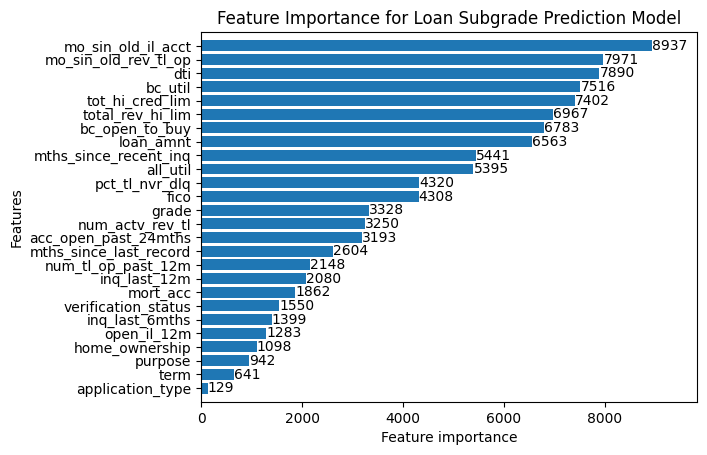

In [3]:
selector_model = LGBMClassifier(verbose=-1, random_state=42)
selector_model.fit(X_train, y_train)
lgbm.plot_importance(selector_model, height=0.8, grid=False, ignore_zero=False)
plt.title("Feature Importance for Loan Subgrade Prediction Model")
plt.show()

Necessary subfunctions for Optuna objective function defined.

In [4]:
def instantiate_feature_selector(trial: Trial) -> SelectFromModel:
    params = {
        "threshold": -np.inf,
        "prefit": True,
        "max_features": trial.suggest_int("max_features", 13, 25),
    }
    feature_selector = SelectFromModel(selector_model, **params).set_output(
        transform="pandas"
    )
    return feature_selector


def instantiate_lightgbm(trial: Trial) -> LGBMClassifier:
    params = {
        "verbosity": -1,
        "n_jobs": -1,
        "random_state": 42,
        "objective": "multiclass",
        "num_class": 35,
        "boosting_type": "gbdt",
        "metric": "auc_mu",
        "early_stopping_rounds": 10,
        "reg_lambda": trial.suggest_float("reg_lambda", 1e-4, 10, log=True),
        "reg_alpha": trial.suggest_float("reg_alpha", 1e-4, 10, log=True),
        "subsample": trial.suggest_float("subsample", 0.4, 1.0, step=0.1),
        "colsample_bytree": trial.suggest_float(
            "colsample_bytree", 0.4, 1.0, step=0.1
        ),
        "max_depth": trial.suggest_int("max_depth", 2, 31),
        "min_child_weight": trial.suggest_float(
            "min_child_weight", 0.01, 1000
        ),
        "num_leaves": trial.suggest_int("num_leaves", 7, 127),
    }
    return LGBMClassifier(**params)


def instantiate_model(trial: Trial) -> Pipeline:
    pipeline = Pipeline([
        ("selector", instantiate_feature_selector(trial)),
        ("estimator", instantiate_lightgbm(trial)),
    ])
    return pipeline

Optuna study defined and run.

In [5]:
def objective(trial: Trial) -> float:
    model = instantiate_model(trial)
    prepro = model[:-1].fit(X_train)
    X_val_prepro = prepro.transform(X_val)
    pruning_callback = optuna.integration.LightGBMPruningCallback(
        trial, "auc_mu"
    )
    model.fit(
        X_train,
        y_train,
        estimator__eval_set=[(X_val_prepro, y_val)],
        estimator__eval_metric=["auc_mu"],
        estimator__callbacks=[pruning_callback],
    )
    trial.set_user_attr("n_estimators", model[-1].best_iteration_ + 1)
    y_pred = model.predict_proba(X_val)
    value = roc_auc_score(y_val, y_pred, average="macro", multi_class="ovo")
    return value


pruner = optuna.pruners.MedianPruner(n_warmup_steps=5, n_min_trials=5)
study = optuna.create_study(
    study_name="subgrade_model_hypertune",
    storage="sqlite:///subgrade_model_hypertune.db",
    load_if_exists=True,
    pruner=pruner,
    direction="maximize",
)
study.optimize(objective, n_trials=100)
best_trial = study.best_trial
n_estimators = best_trial.user_attrs["n_estimators"]
print("Best macro-averaged ROC AUC:", study.best_value)
print("Best parameters:")
display(study.best_params)

[I 2024-02-07 01:23:18,283] A new study created in RDB with name: subgrade_model_hypertune
[I 2024-02-07 01:24:41,437] Trial 0 finished with value: 0.9448146186519732 and parameters: {'max_features': 17, 'reg_lambda': 0.00908164178052774, 'reg_alpha': 0.09531015887096354, 'subsample': 0.7000000000000001, 'colsample_bytree': 0.5, 'max_depth': 9, 'min_child_weight': 179.64074361734697, 'num_leaves': 42}. Best is trial 0 with value: 0.9448146186519732.
[I 2024-02-07 01:25:07,593] Trial 1 finished with value: 0.5 and parameters: {'max_features': 14, 'reg_lambda': 0.29778869892699816, 'reg_alpha': 0.00012202322503279343, 'subsample': 0.6000000000000001, 'colsample_bytree': 1.0, 'max_depth': 25, 'min_child_weight': 928.2736392983641, 'num_leaves': 104}. Best is trial 0 with value: 0.9448146186519732.
[I 2024-02-07 01:26:38,034] Trial 2 finished with value: 0.9464258486640272 and parameters: {'max_features': 25, 'reg_lambda': 0.0028888952362066222, 'reg_alpha': 0.0008976697493581631, 'subsamp

Best macro-averaged ROC AUC: 0.9483623664896954
Best parameters:


{'max_features': 25,
 'reg_lambda': 0.034111358234840586,
 'reg_alpha': 0.4031740266872948,
 'subsample': 0.7000000000000001,
 'colsample_bytree': 0.7000000000000001,
 'max_depth': 27,
 'min_child_weight': 83.15066979556568,
 'num_leaves': 92}

The final tuned model obtained.

In [10]:
subgrade_model = instantiate_model(best_trial)
subgrade_model.set_params(
    estimator__n_estimators=n_estimators,
    estimator__early_stopping_rounds=None,
    estimator__callbacks=None,
)
subgrade_model

Pipeline(steps=[('selector',
                 SelectFromModel(estimator=LGBMClassifier(random_state=42,
                                                          verbose=-1),
                                 max_features=25, prefit=True,
                                 threshold=-inf)),
                ('estimator',
                 LGBMClassifier(callbacks=None,
                                colsample_bytree=0.7000000000000001,
                                early_stopping_rounds=None, max_depth=27,
                                metric='auc_mu',
                                min_child_weight=83.15066979556568,
                                n_estimators=32, n_jobs=-1, num_class=35,
                                num_leaves=92, objective='multiclass',
                                random_state=42, reg_alpha=0.4031740266872948,
                                reg_lambda=0.034111358234840586,
                                subsample=0.7000000000000001, verbosity=-1))])

Model fitted to the whole undersampled training data (training and validation sets) and dumped for later use.

In [11]:
X_train, y_train = (
    pd.concat([
        pd.read_pickle("./data/data_train_mod2.pkl"),
        pd.read_pickle("./data/data_val_mod2.pkl"),
    ])
    .drop(columns=drop_cols)
    .pipe(X_y_spilt, target="sub_grade_enc")
)
X_train, y_train = rus.fit_resample(X_train, y_train)
subgrade_model.fit(X_train, y_train)
joblib.dump(subgrade_model, "./tuned_models/subgrade_model.joblib")

['./tuned_models/subgrade_model.joblib']